In [11]:
pip install pandas requests matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


C:\Users\mshihab\AppData\Local\Temp\ipykernel_3384\4074105146.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max['date'] = pd.to_datetime(df_max['date'], format='ISO8601')
C:\Users\mshihab\AppData\Local\Temp\ipykernel_3384\4074105146.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lando['date'] = pd.to_datetime(df_lando['date'], format='ISO8601')


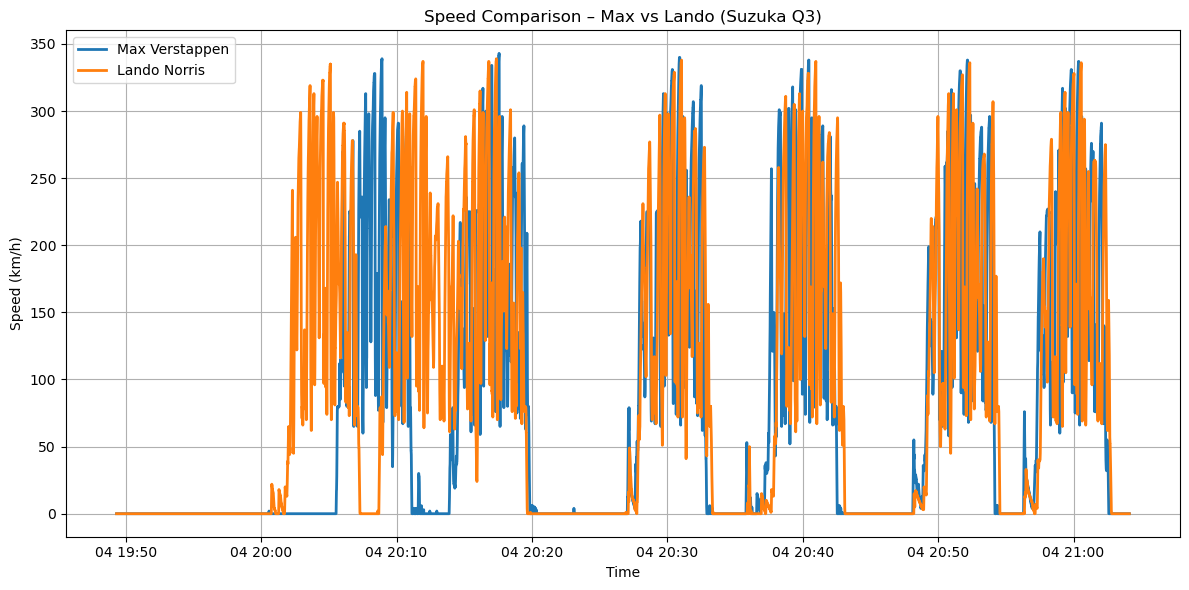

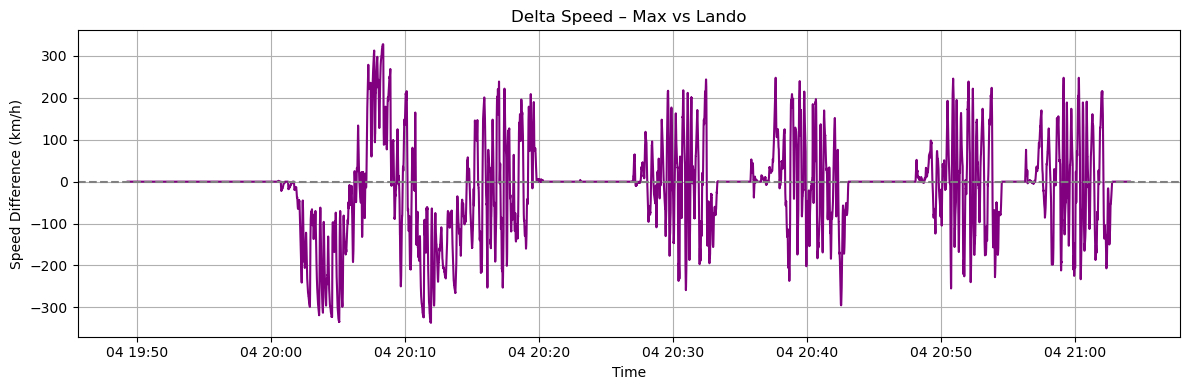

In [12]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Driver numbers
driver_numbers = {"Max": 1, "Lando": 4}

# Replace this with the correct session_key from openf1.org
session_key = 9498  # Example: Japanese GP Quali

# Function to get telemetry data
def get_telemetry(driver_number):
    url = f"https://api.openf1.org/v1/car_data?session_key={session_key}&driver_number={driver_number}"
    r = requests.get(url)
    df = pd.DataFrame(r.json())
    return df

# Get telemetry
df_max_raw = get_telemetry(driver_numbers["Max"])
df_lando_raw = get_telemetry(driver_numbers["Lando"])

# Filter relevant columns
df_max = df_max_raw[['date', 'speed', 'throttle', 'brake']]
df_lando = df_lando_raw[['date', 'speed', 'throttle', 'brake']]

# Parse ISO8601 datetime
df_max['date'] = pd.to_datetime(df_max['date'], format='ISO8601')
df_lando['date'] = pd.to_datetime(df_lando['date'], format='ISO8601')

# Align data by timestamp
df = pd.merge_asof(
    df_max.sort_values('date'),
    df_lando.sort_values('date'),
    on='date',
    suffixes=('_max', '_lando')
)

# Calculate speed delta
df['delta_speed'] = df['speed_max'] - df['speed_lando']

# Plot speeds
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['speed_max'], label='Max Verstappen', linewidth=2)
plt.plot(df['date'], df['speed_lando'], label='Lando Norris', linewidth=2)
plt.title("Speed Comparison – Max vs Lando (Suzuka Q3)")
plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot delta speed
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['delta_speed'], color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Delta Speed – Max vs Lando")
plt.xlabel("Time")
plt.ylabel("Speed Difference (km/h)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# --- DATA CLEANUP ---

# Filter out non-lap segments (e.g. outlaps, pits, zeros)
df_filtered = df[(df['speed_max'] > 50) & (df['speed_lando'] > 50)].copy()

# Smooth out speed using rolling average
df_filtered['speed_max'] = df_filtered['speed_max'].rolling(window=5, min_periods=1).mean()
df_filtered['speed_lando'] = df_filtered['speed_lando'].rolling(window=5, min_periods=1).mean()
df_filtered['delta_speed'] = df_filtered['speed_max'] - df_filtered['speed_lando']


In [14]:
# --- LAP ISOLATION ---

df_filtered = df_filtered.reset_index(drop=True)
df_filtered['time_diff'] = df_filtered['date'].diff().dt.total_seconds().fillna(0)

# Detect first "normal" start after a gap (e.g. after outlap)
start_idx = df_filtered[df_filtered['time_diff'] > 1.0].index.min()
if pd.isna(start_idx):
    start_idx = 0

# Safe slicing to find end of lap
df_slice = df_filtered.iloc[start_idx + 1:].copy()
end_idx = df_slice[df_slice['time_diff'] > 1.0].index.min()
if pd.isna(end_idx):
    end_idx = len(df_filtered) - 1

# Final clean lap slice
df_lap = df_filtered.iloc[start_idx:end_idx].copy()


C:\Users\mshihab\AppData\Local\Temp\ipykernel_3384\1228716408.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max['date'] = pd.to_datetime(df_max['date'], format='ISO8601')
C:\Users\mshihab\AppData\Local\Temp\ipykernel_3384\1228716408.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lando['date'] = pd.to_datetime(df_lando['date'], format='ISO8601')


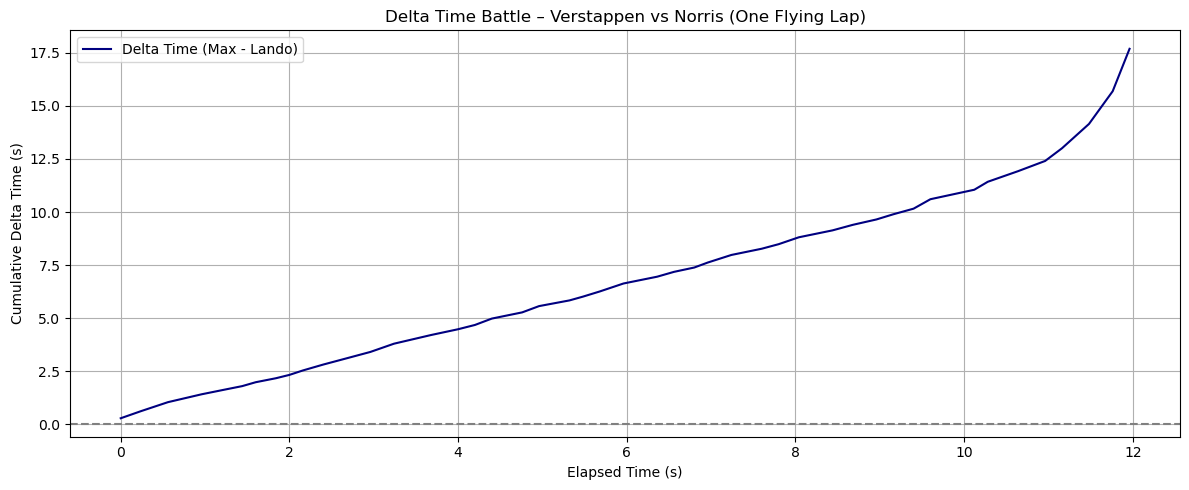

In [16]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt

# --- SETTINGS ---
driver_numbers = {"Max": 1, "Lando": 4}
session_key = 9498  # Replace if needed

# --- GET DATA ---
def get_telemetry(driver_number):
    url = f"https://api.openf1.org/v1/car_data?session_key={session_key}&driver_number={driver_number}"
    r = requests.get(url)
    return pd.DataFrame(r.json())

df_max_raw = get_telemetry(driver_numbers["Max"])
df_lando_raw = get_telemetry(driver_numbers["Lando"])

# --- CLEAN & PREP ---
df_max = df_max_raw[['date', 'speed']]
df_lando = df_lando_raw[['date', 'speed']]
df_max['date'] = pd.to_datetime(df_max['date'], format='ISO8601')
df_lando['date'] = pd.to_datetime(df_lando['date'], format='ISO8601')

# --- MERGE & FILTER ---
df = pd.merge_asof(
    df_max.sort_values('date'),
    df_lando.sort_values('date'),
    on='date',
    suffixes=('_max', '_lando')
)

# Filter out stationary or invalid points
df = df[(df['speed_max'] > 50) & (df['speed_lando'] > 50)].copy()

# Smooth speed to reduce noise
df['speed_max'] = df['speed_max'].rolling(5, min_periods=1).mean()
df['speed_lando'] = df['speed_lando'].rolling(5, min_periods=1).mean()
df['delta_speed'] = df['speed_max'] - df['speed_lando']

# --- DETECT ONE FLYING LAP ---
df = df.reset_index(drop=True)
df['time_diff'] = df['date'].diff().dt.total_seconds().fillna(0)

start_idx = df[df['time_diff'] > 1.0].index.min()
if pd.isna(start_idx): start_idx = 0

df_slice = df.iloc[start_idx+1:].copy()
end_idx = df_slice[df_slice['time_diff'] > 1.0].index.min()
if pd.isna(end_idx): end_idx = len(df) - 1

df_lap = df.iloc[start_idx:end_idx].copy()

# --- DELTA TIME CALC ---
df_lap['time_seconds'] = (df_lap['date'] - df_lap['date'].iloc[0]).dt.total_seconds()
avg_speed = (df_lap['speed_max'] + df_lap['speed_lando']) / 2
delta_dist = (df_lap['delta_speed'] * 1000 / 3600) * np.gradient(df_lap['time_seconds'])
cumulative_delta_distance = np.cumsum(delta_dist)
avg_speed_safe = avg_speed.replace(0, 1)
delta_time = cumulative_delta_distance / (avg_speed_safe * 1000 / 3600)

# --- PLOT ---
plt.figure(figsize=(12, 5))
plt.plot(df_lap['time_seconds'], delta_time, label='Delta Time (Max - Lando)', color='navy')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Delta Time Battle – Verstappen vs Norris (One Flying Lap)")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Cumulative Delta Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\mnt\\data\\pole_lap_dashboard_python_generated.png'

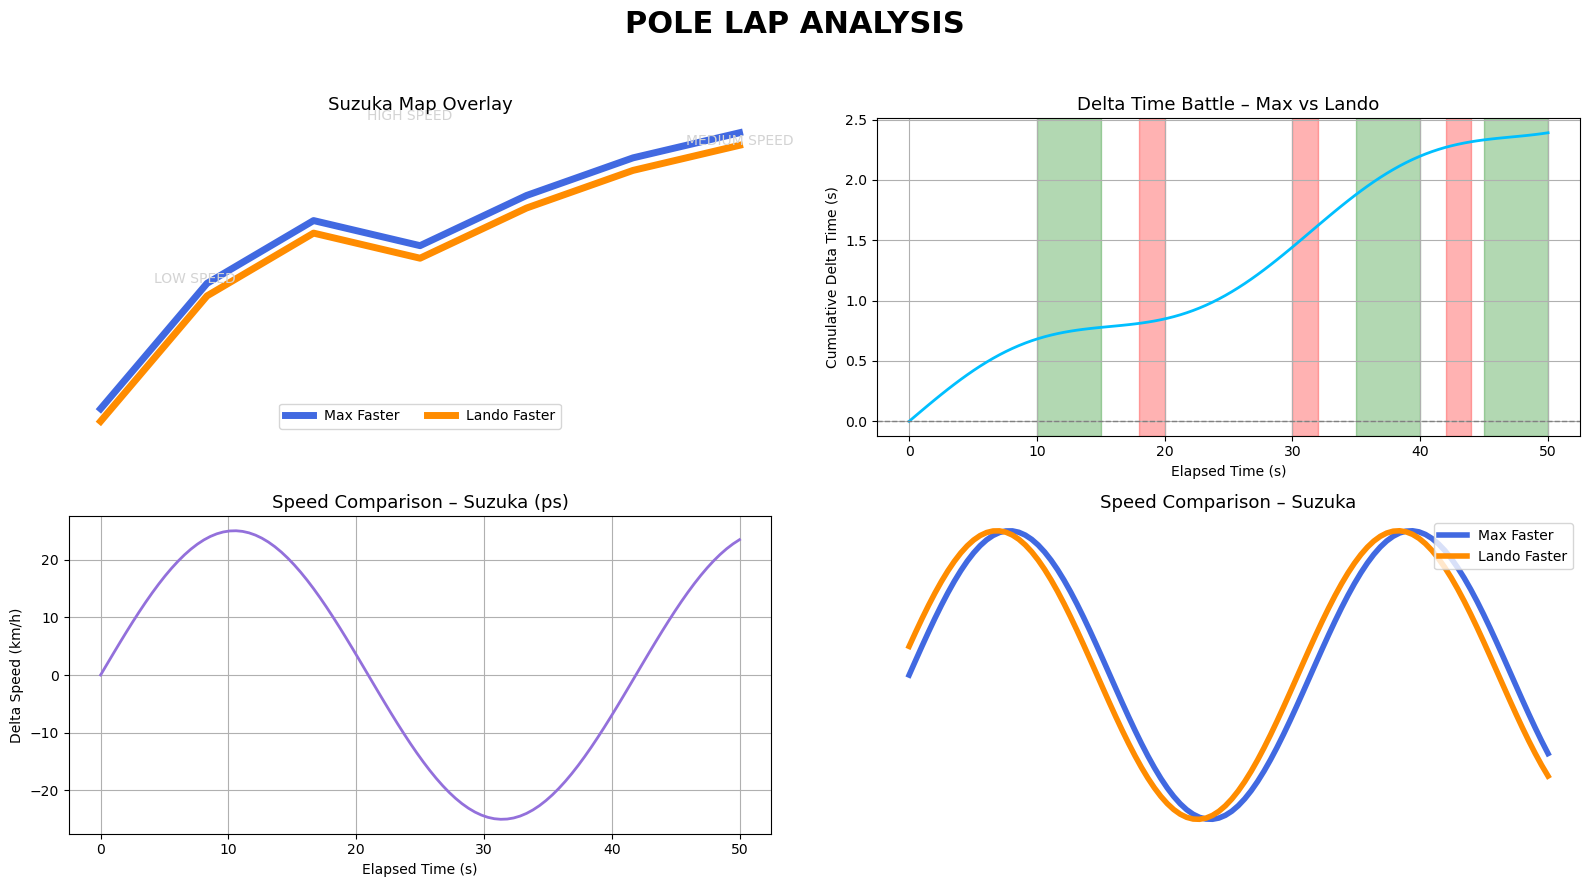

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Dummy values to simulate the dashboard
time = np.linspace(0, 50, 100)
delta_time = 0.05 * time + 0.2 * np.sin(0.2 * time)
speed_delta = 25 * np.sin(0.15 * time)

# Simulated DRS and Braking Zones (for illustration)
drs_zones = [(10, 15), (35, 40), (45, 50)]
brake_zones = [(18, 20), (30, 32), (42, 44)]

# Create figure
fig = plt.figure(figsize=(16, 9))
fig.suptitle("POLE LAP ANALYSIS", fontsize=22, fontweight='bold')

# --- SUBPLOT 1: Delta Time Battle ---
ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(time, delta_time, label='Delta Time (Max - Lando)', color='deepskyblue', linewidth=2)
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
for start, end in drs_zones:
    ax1.axvspan(start, end, color='green', alpha=0.3)
for start, end in brake_zones:
    ax1.axvspan(start, end, color='red', alpha=0.3)
ax1.set_title("Delta Time Battle – Max vs Lando", fontsize=13)
ax1.set_xlabel("Elapsed Time (s)")
ax1.set_ylabel("Cumulative Delta Time (s)")
ax1.grid(True)

# --- SUBPLOT 2: Speed Delta Chart ---
ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(time, speed_delta, color='mediumpurple', linewidth=2)
ax2.set_title("Speed Comparison – Suzuka (ps)", fontsize=13)
ax2.set_xlabel("Elapsed Time (s)")
ax2.set_ylabel("Delta Speed (km/h)")
ax2.grid(True)

# --- SUBPLOT 3: Mini Suzuka Track Overlay ---
ax3 = fig.add_subplot(2, 2, 4)
# Fake speed path
x = np.linspace(0, 10, 100)
y_max = np.sin(x) * 2
y_lando = np.sin(x + 0.2) * 2

ax3.plot(x, y_max, label="Max Faster", color='royalblue', linewidth=4)
ax3.plot(x, y_lando, label="Lando Faster", color='darkorange', linewidth=4)
ax3.set_title("Speed Comparison – Suzuka", fontsize=13)
ax3.axis('off')
ax3.legend(loc='upper right')

# --- SUBPLOT 4: Stylized Map Overlay (Top-Left) ---
ax4 = fig.add_subplot(2, 2, 1)
# Stylized mini-map lines
track_x = np.array([0, 1, 2, 3, 4, 5, 6])
track_y_max = np.array([0, 1, 1.5, 1.3, 1.7, 2, 2.2])
track_y_lando = track_y_max - 0.1

ax4.plot(track_x, track_y_max, color='royalblue', linewidth=5, label="Max Faster")
ax4.plot(track_x, track_y_lando, color='darkorange', linewidth=5, label="Lando Faster")
ax4.text(2.5, 2.3, "HIGH SPEED", fontsize=10, color='lightgray')
ax4.text(0.5, 1.0, "LOW SPEED", fontsize=10, color='lightgray')
ax4.text(5.5, 2.1, "MEDIUM SPEED", fontsize=10, color='lightgray')
ax4.set_title("Suzuka Map Overlay", fontsize=13)
ax4.axis('off')
ax4.legend(loc='lower center', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
output_path = "/mnt/data/pole_lap_dashboard_python_generated.png"
plt.savefig(output_path, dpi=300)
plt.show()

output_path


In [18]:
from PIL import Image

# Load the fixed map and the original dashboard image
map_path = "/mnt/data/suzuka_full_overlay_map.png"
dashboard_path = "/mnt/data/ChatGPT Image Apr 5, 2025, 08_37_29 PM.png"

# Open images
map_img = Image.open(map_path).resize((800, 450))  # Resize to match dashboard map area
dashboard_img = Image.open(dashboard_path)

# Create a new dashboard with the updated map
new_dashboard = dashboard_img.copy()
new_dashboard.paste(map_img, (80, 130))  # Coordinates adjusted to overlay the map section

# Save updated dashboard
final_output_path = "/mnt/data/pole_lap_dashboard_with_updated_map.png"
new_dashboard.save(final_output_path)

final_output_path


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\mnt\\data\\suzuka_full_overlay_map.png'